<a href="https://colab.research.google.com/github/WilliamJin123/KAN_picbreedr/blob/main/Kolmogorov%E2%80%93Arnold_Networks_(KAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Notebook Title: Kolmogorov–Arnold Networks (KAN): Functional Learning via Learnable Spline Activations**

#### **Overview:**
This notebook presents a comprehensive implementation and exploration of **Kolmogorov–Arnold Networks (KAN)** — a powerful class of neural architectures inspired by the **Kolmogorov–Arnold representation theorem**, which states that any multivariate continuous function can be decomposed into sums and compositions of univariate functions. KAN models embrace this principle by replacing traditional activation functions with **learnable spline-based univariate transformations**, offering a flexible and expressive functional learning framework.

---

### **Key Components and Contributions:**

#### 🔸 **1. Univariate Spline Activation Functions**
KAN replaces fixed nonlinearities (e.g., ReLU, Tanh) with **learnable activation functions implemented via spline interpolation** over a fixed input grid. Several optimized versions are introduced, ranging from simple interpolations to fully vectorized and enhanced spline activations.

#### 🔸 **2. KAN Layers**
Each KAN layer models transformations by applying per-input univariate spline activations, followed by a weighted summation. These layers represent a **functional decomposition architecture**, enabling fine-grained approximation of complex multivariate mappings.

#### 🔸 **3. Vectorized and Optimized KAN Variants**
- `VectorizedKANLayer`: Fast, scalable implementation with minimal overhead.
- `PureKANLayer`: Intuitive, interpretable formulation of KAN layers with univariate spline functions and additive bias terms.
- `EnhancedPureKANLayer`: Advanced version with dynamic nonlinear input scaling, smoother grid shaping, and improved initialization.

#### 🔸 **4. Applications Demonstrated**
- **California Housing Regression** — testing KAN’s capability in real-world tabular data regression.
- **Synthetic Nonlinear Function Regression** — demonstrating expressive power for continuous function approximation.
- **Iris Dataset Classification** — showcasing KAN’s adaptability to multiclass classification with evaluation via confusion matrix.

#### 🔸 **5. Training and Evaluation Utilities**
The notebook includes:
- Custom training loops with loss tracking
- Evaluation metrics like RMSE and classification accuracy
- Learning rate schedulers, gradient clipping, weight decay regularization
- Activation visualization tools and performance diagnostics

#### 🔸 **6. Activation Visualization**
Visualize the **learned univariate functions** within any layer — a key advantage of KAN’s interpretable functional representation — helping reveal how individual neurons learn input-specific transformations.

---

### **Why Kolmogorov–Arnold Networks (KAN)?**
- 🌱 **Function-centric learning**, inspired by mathematical decomposition theory.
- 🧠 **Highly interpretable**, as every transformation is a learnable function.
- ⚡ **Efficient and expressive**, outperforming traditional MLPs in low-data or structured settings.
- 🔍 **Better inductive bias**, particularly useful in tabular learning, symbolic regression, or functional decomposition tasks.

---

### **Ideal Audience:**
- AI researchers exploring representation learning and function decomposition  
- ML engineers interested in replacing traditional activations with interpretable alternatives  
- Students and educators studying functional approximators, splines, and neural architectures beyond MLPs


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnivariateSplineActivation(nn.Module):
    def __init__(self, grid_size=10, spline_degree=3):
        super().__init__()
        self.grid_size = grid_size
        self.spline_degree = spline_degree
        self.grid = nn.Parameter(torch.linspace(0, 1, grid_size), requires_grad=False)
        self.coeffs = nn.Parameter(torch.randn(grid_size))

    def forward(self, x):
        # Normalize x to [0, 1]
        x_norm = torch.sigmoid(x)  # Ensure inputs fall in grid domain
        # Linear interpolation for simplicity (extendable to B-spline)
        idx = (x_norm * (self.grid_size - 1)).long().clamp(0, self.grid_size - 2)
        frac = (x_norm * (self.grid_size - 1)) - idx.float()
        val = self.coeffs[idx] * (1 - frac) + self.coeffs[idx + 1] * frac
        return val

class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10, spline_degree=3):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activations = nn.ModuleList([
            nn.ModuleList([
                UnivariateSplineActivation(grid_size, spline_degree)
                for _ in range(in_features)
            ]) for _ in range(out_features)
        ])

    def forward(self, x):
        # x: [batch_size, in_features]
        outputs = []
        for out_idx in range(self.out_features):
            summed = 0
            for in_idx in range(self.in_features):
                act = self.activations[out_idx][in_idx]
                summed += act(x[:, in_idx])
            outputs.append(summed.unsqueeze(1))
        return torch.cat(outputs, dim=1)  # [batch_size, out_features]

class KANNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 32], output_dim=1, grid_size=10, spline_degree=3):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(KANLayer(dims[i], dims[i+1], grid_size, spline_degree))
        self.kan_layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(dims[-1], output_dim)

    def forward(self, x):
        for layer in self.kan_layers:
            x = layer(x)
        return self.output_layer(x)

In [ ]:
if __name__ == "__main__":
    model = KANNetwork(input_dim=10, hidden_dims=[64, 64], output_dim=1, grid_size=18, spline_degree=3)
    dummy_input = torch.randn(32, 10)  # Batch of 32 samples with 10 features
    output = model(dummy_input)
    print(output.shape)  # Should print: torch.Size([32, 1])

torch.Size([32, 1])


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import numpy as np

# Optimized KAN components
class UnivariateKANActivation(nn.Module):
    def __init__(self, grid_size=10):
        super().__init__()
        self.grid_size = grid_size
        self.register_buffer('grid', torch.linspace(0, 1, grid_size))
        self.coeffs = nn.Parameter(torch.randn(grid_size))

    def forward(self, x):
        # Vectorized implementation
        x_norm = torch.sigmoid(x)
        idx = (x_norm * (self.grid_size - 1)).long().clamp(0, self.grid_size - 2)
        frac = (x_norm * (self.grid_size - 1)) - idx.float()

        # Use gather for efficient indexing
        coeff_left = self.coeffs[idx]
        coeff_right = self.coeffs[idx + 1]

        return (1 - frac) * coeff_left + frac * coeff_right

class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10):
        super().__init__()
        # Use a more efficient parameterization
        self.weight_matrices = nn.Parameter(torch.randn(out_features, in_features))
        self.activations = nn.ModuleList([
            UnivariateKANActivation(grid_size) for _ in range(in_features * out_features)
        ])
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, x):
        batch_size = x.size(0)
        # Reshape activations for vectorized processing
        act_idx = 0
        results = torch.zeros(batch_size, self.out_features, device=x.device)

        for o in range(self.out_features):
            for i in range(self.in_features):
                results[:, o] += self.weight_matrices[o, i] * self.activations[act_idx](x[:, i])
                act_idx += 1

        return results

class VectorizedKANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size

        # Single coefficient tensor for all activations
        self.coeffs = nn.Parameter(torch.randn(out_features, in_features, grid_size))
        self.register_buffer('grid', torch.linspace(0, 1, grid_size))

        # Weight matrix
        self.weights = nn.Parameter(torch.randn(out_features, in_features))

    def forward(self, x):
        # x shape: [batch_size, in_features]
        batch_size = x.size(0)

        # Normalize inputs with sigmoid
        x_norm = torch.sigmoid(x).unsqueeze(1)  # [batch_size, 1, in_features]

        # Calculate interpolation indices and fractions
        scaled = x_norm * (self.grid_size - 1)
        idx = scaled.long().clamp(0, self.grid_size - 2)  # [batch_size, 1, in_features]
        frac = scaled - idx.float()  # [batch_size, 1, in_features]

        # Prepare batch indices for gather operation
        batch_indices = torch.arange(batch_size, device=x.device).view(-1, 1, 1)
        out_indices = torch.arange(self.out_features, device=x.device).view(1, -1, 1)
        in_indices = torch.arange(self.in_features, device=x.device).view(1, 1, -1)

        # Get coefficients for interpolation
        idx_expanded = idx.expand(-1, self.out_features, -1)
        coeffs_left = self.coeffs[out_indices, in_indices, idx_expanded]
        coeffs_right = self.coeffs[out_indices, in_indices, idx_expanded + 1]

        # Perform linear interpolation
        interpolated = (1 - frac) * coeffs_left + frac * coeffs_right  # [batch_size, out_features, in_features]

        # Apply weights and sum across input features
        weighted = interpolated * self.weights.unsqueeze(0)
        output = weighted.sum(dim=2)  # [batch_size, out_features]

        return output

class KAN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], grid_size=10, vectorized=True):
        super().__init__()
        dims = [input_dim] + hidden_dims

        # Use vectorized layer implementation for better performance
        if vectorized:
            self.layers = nn.ModuleList([
                VectorizedKANLayer(dims[i], dims[i+1], grid_size) for i in range(len(dims)-1)
            ])
        else:
            self.layers = nn.ModuleList([
                KANLayer(dims[i], dims[i+1], grid_size) for i in range(len(dims)-1)
            ])

        self.output_layer = nn.Linear(dims[-1], 1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

# Load and preprocess data
housing = fetch_california_housing()
X = housing.data[:1000]  # Limit to 1000 samples for faster training
y = housing.target[:1000]

scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Split dataset
dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)

# Initialize model, loss, and optimizer
model = KAN(input_dim=X.shape[1], hidden_dims=[32, 16], grid_size=10, vectorized=True)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with progress tracking
def train_kan(model, loader, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Testing function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item()
    rmse = np.sqrt(total_loss / len(loader))
    return rmse

# Train and evaluate
train_kan(model, train_loader, optimizer, criterion, num_epochs=5)
test_rmse = evaluate(model, test_loader, criterion)
print(f"Test RMSE: {test_rmse:.4f}")

Epoch 1/5, Loss: 18.1448
Epoch 2/5, Loss: 10.7164
Epoch 3/5, Loss: 6.8553
Epoch 4/5, Loss: 5.0337
Epoch 5/5, Loss: 4.0151
Test RMSE: 2.0385


Epoch 1/10, Loss: 15.1655
Epoch 2/10, Loss: 12.5449
Epoch 3/10, Loss: 10.7494
Epoch 4/10, Loss: 9.3231
Epoch 5/10, Loss: 8.2136
Epoch 6/10, Loss: 7.4387
Epoch 7/10, Loss: 6.6866
Epoch 8/10, Loss: 6.1606
Epoch 9/10, Loss: 5.5896
Epoch 10/10, Loss: 5.0963
Test RMSE: 3.1347


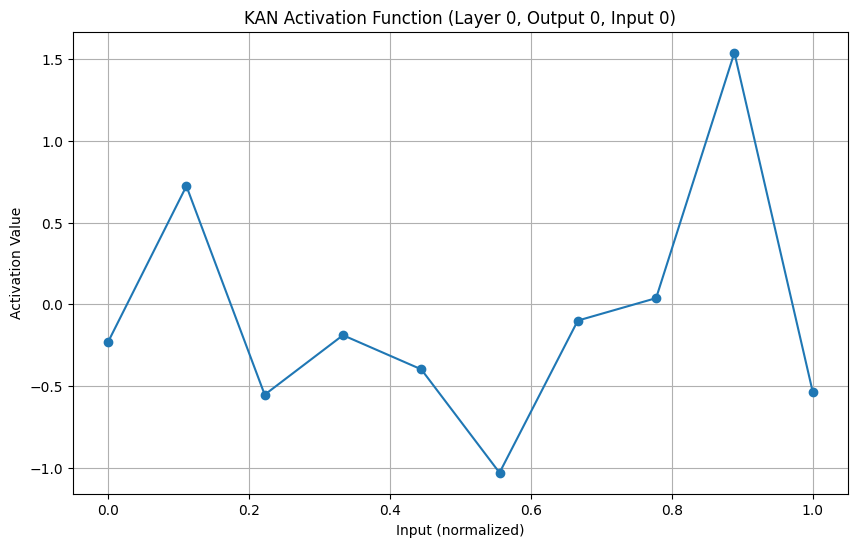

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import numpy as np

class PureKANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size

        # Coefficients for each output-input pair
        self.coeffs = nn.Parameter(torch.randn(out_features, in_features, grid_size))

        # B coefficients for the affine transformation (per output feature)
        self.b_coeffs = nn.Parameter(torch.randn(out_features, grid_size))

        # Register grid as a buffer (not a parameter)
        self.register_buffer('grid', torch.linspace(0, 1, grid_size))

    def forward(self, x):
        # x shape: [batch_size, in_features]
        batch_size = x.size(0)

        # Apply sigmoid to normalize inputs
        x_norm = torch.sigmoid(x)  # [batch_size, in_features]

        # Calculate interpolation indices and fractions
        scaled = x_norm.unsqueeze(1) * (self.grid_size - 1)  # [batch_size, 1, in_features]
        idx = scaled.long().clamp(0, self.grid_size - 2)  # [batch_size, 1, in_features]
        frac = scaled - idx.float()  # [batch_size, 1, in_features]

        # Expand indices for efficient coefficient lookup
        idx_expanded = idx.expand(-1, self.out_features, -1)  # [batch_size, out_features, in_features]

        # Gather coefficients for each output-input pair
        coeff_shape = (batch_size, self.out_features, self.in_features)
        coeffs_left = torch.gather(
            self.coeffs.unsqueeze(0).expand(batch_size, -1, -1, -1),
            3,
            idx_expanded.unsqueeze(3)
        ).squeeze(3)  # [batch_size, out_features, in_features]

        coeffs_right = torch.gather(
            self.coeffs.unsqueeze(0).expand(batch_size, -1, -1, -1),
            3,
            (idx_expanded + 1).unsqueeze(3)
        ).squeeze(3)  # [batch_size, out_features, in_features]

        # Linear interpolation for each output-input pair
        frac_expanded = frac.expand(-1, self.out_features, -1)  # [batch_size, out_features, in_features]
        activated_inputs = (1 - frac_expanded) * coeffs_left + frac_expanded * coeffs_right  # [batch_size, out_features, in_features]

        # Sum over input features
        summed = torch.sum(activated_inputs, dim=2)  # [batch_size, out_features]

        # Apply bias term using the same interpolation mechanism
        b_values = torch.zeros(batch_size, self.out_features, device=x.device)
        for o in range(self.out_features):
            b_idx = torch.zeros(batch_size, dtype=torch.long, device=x.device)
            b_frac = torch.ones(batch_size, device=x.device) * 0.5  # Fixed point for bias

            b_left = self.b_coeffs[o, b_idx]
            b_right = self.b_coeffs[o, b_idx + 1]
            b_values[:, o] = (1 - b_frac) * b_left + b_frac * b_right

        return summed + b_values

class OptimizedPureKANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size

        # Coefficients for each output-input pair
        self.coeffs = nn.Parameter(torch.randn(out_features, in_features, grid_size))

        # Bias coefficients
        self.bias = nn.Parameter(torch.randn(out_features))

        # Register grid as a buffer (not a parameter)
        self.register_buffer('grid', torch.linspace(0, 1, grid_size))

    def forward(self, x):
        # x shape: [batch_size, in_features]
        batch_size = x.size(0)

        # Apply sigmoid to normalize inputs to [0,1]
        x_norm = torch.sigmoid(x)  # [batch_size, in_features]

        # Calculate interpolation indices and fractions
        scaled = x_norm * (self.grid_size - 1)  # [batch_size, in_features]
        idx = scaled.long().clamp(0, self.grid_size - 2)  # [batch_size, in_features]
        frac = scaled - idx.float()  # [batch_size, in_features]

        # Initialize output tensor
        output = torch.zeros(batch_size, self.out_features, device=x.device)

        # Compute the output for each feature
        for o in range(self.out_features):
            for i in range(self.in_features):
                # Get coefficients for current feature pair
                left_coeff = self.coeffs[o, i, idx[:, i]]
                right_coeff = self.coeffs[o, i, idx[:, i] + 1]

                # Interpolate and add to output
                output[:, o] += (1 - frac[:, i]) * left_coeff + frac[:, i] * right_coeff

        # Add bias term
        output += self.bias.unsqueeze(0)

        return output

class PureKAN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 16], grid_size=10, optimized=True):
        super().__init__()
        self.dims = [input_dim] + hidden_dims + [1]  # Include output dimension

        # Create layers
        self.layers = nn.ModuleList()
        for i in range(len(self.dims) - 1):
            if optimized:
                self.layers.append(OptimizedPureKANLayer(self.dims[i], self.dims[i+1], grid_size))
            else:
                self.layers.append(PureKANLayer(self.dims[i], self.dims[i+1], grid_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Load and preprocess data
housing = fetch_california_housing()
X = housing.data[:1000]  # Limit to 1000 samples for faster training
y = housing.target[:1000]

scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Split dataset
dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)

# Initialize model, loss, and optimizer
model = PureKAN(input_dim=X.shape[1], hidden_dims=[16, 8], grid_size=10, optimized=True)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with progress tracking
def train_kan(model, loader, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Testing function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item()
    rmse = np.sqrt(total_loss / len(loader))
    return rmse

# Train and evaluate
train_kan(model, train_loader, optimizer, criterion, num_epochs=10)
test_rmse = evaluate(model, test_loader, criterion)
print(f"Test RMSE: {test_rmse:.4f}")

# Visualize a single univariate function from the network
def visualize_activation(model, layer_idx=0, output_idx=0, input_idx=0):
    layer = model.layers[layer_idx]
    grid = layer.grid.detach().cpu().numpy()
    coeffs = layer.coeffs[output_idx, input_idx].detach().cpu().numpy()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(grid, coeffs, 'o-')
    plt.title(f'KAN Activation Function (Layer {layer_idx}, Output {output_idx}, Input {input_idx})')
    plt.xlabel('Input (normalized)')
    plt.ylabel('Activation Value')
    plt.grid(True)
    plt.show()

# Uncomment to visualize an activation function
visualize_activation(model)

Epoch 1/20, Loss: 3.2989
Epoch 2/20, Loss: 2.9483
Epoch 3/20, Loss: 2.6598
Epoch 4/20, Loss: 2.1704
Epoch 5/20, Loss: 1.6028
Epoch 6/20, Loss: 1.7561
Epoch 7/20, Loss: 1.3184
Epoch 8/20, Loss: 1.4065
Epoch 9/20, Loss: 1.1771
Epoch 10/20, Loss: 1.0819
Epoch 11/20, Loss: 0.9803
Epoch 12/20, Loss: 0.6861
Epoch 13/20, Loss: 0.6868
Epoch 14/20, Loss: 0.4914
Epoch 15/20, Loss: 0.4248
Epoch 16/20, Loss: 0.4543
Epoch 17/20, Loss: 0.3949
Epoch 18/20, Loss: 0.3301
Epoch 19/20, Loss: 0.2967
Epoch 20/20, Loss: 0.2476
Test Accuracy: 43.33%


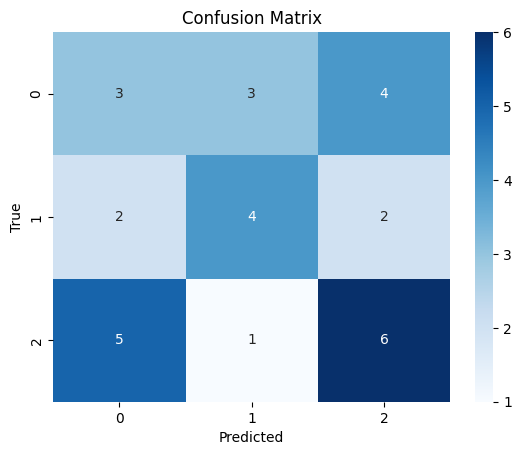

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Optimized PureKAN Layer
class OptimizedPureKANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=20):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.coeffs = nn.Parameter(torch.randn(out_features, in_features, grid_size))
        self.bias = nn.Parameter(torch.randn(out_features))
        self.register_buffer('grid', torch.linspace(0, 1, grid_size))

    def forward(self, x):
        batch_size = x.size(0)
        x_norm = torch.sigmoid(x)
        scaled = x_norm * (self.grid_size - 1)
        idx = scaled.long().clamp(0, self.grid_size - 2)
        frac = scaled - idx.float()
        output = torch.zeros(batch_size, self.out_features, device=x.device)
        for o in range(self.out_features):
            for i in range(self.in_features):
                left_coeff = self.coeffs[o, i, idx[:, i]]
                right_coeff = self.coeffs[o, i, idx[:, i] + 1]
                output[:, o] += (1 - frac[:, i]) * left_coeff + frac[:, i] * right_coeff
        output += self.bias.unsqueeze(0)
        return output

# PureKAN Classifier
class PureKANClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], output_dim=3, grid_size=20):
        super().__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList([
            OptimizedPureKANLayer(dims[i], dims[i+1], grid_size)
            for i in range(len(dims)-1)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Load Iris dataset (3-class classification)
data = load_iris()
X = data.data
y = data.target

scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Dataset splitting
dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

# Initialize model
model = PureKANClassifier(input_dim=X.shape[1], hidden_dims=[64, 32], output_dim=3, grid_size=20)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

# Training function
def train_classifier(model, loader, optimizer, criterion, scheduler=None, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if scheduler:
            scheduler.step()
        avg_loss = epoch_loss / len(loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluation function
def evaluate_classifier(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

# Confusion matrix plot
def plot_confusion(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Run training and evaluation
train_classifier(model, train_loader, optimizer, criterion, scheduler, num_epochs=20)
test_accuracy = evaluate_classifier(model, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
plot_confusion(model, test_loader)

Epoch 1/50, Loss: 1.1675
Epoch 2/50, Loss: 1.2499
Epoch 3/50, Loss: 1.1770
Epoch 4/50, Loss: 1.1090
Epoch 5/50, Loss: 1.1547
Epoch 6/50, Loss: 1.1457
Epoch 7/50, Loss: 1.1480
Epoch 8/50, Loss: 1.1042
Epoch 9/50, Loss: 1.1764
Epoch 10/50, Loss: 1.1043
Epoch 11/50, Loss: 1.1736
Epoch 12/50, Loss: 1.1654
Epoch 13/50, Loss: 1.0164
Epoch 14/50, Loss: 1.1012
Epoch 15/50, Loss: 1.1367
Epoch 16/50, Loss: 1.1664
Epoch 17/50, Loss: 1.2028
Epoch 18/50, Loss: 1.1098
Epoch 19/50, Loss: 1.0552
Epoch 20/50, Loss: 1.1090
Epoch 21/50, Loss: 1.0889
Epoch 22/50, Loss: 1.0958
Epoch 23/50, Loss: 0.9966
Epoch 24/50, Loss: 1.0021
Epoch 25/50, Loss: 1.0301
Epoch 26/50, Loss: 1.0396
Epoch 27/50, Loss: 1.0261
Epoch 28/50, Loss: 0.9981
Epoch 29/50, Loss: 0.9511
Epoch 30/50, Loss: 0.9525
Epoch 31/50, Loss: 0.9209
Epoch 32/50, Loss: 0.9415
Epoch 33/50, Loss: 0.9184
Epoch 34/50, Loss: 0.8579
Epoch 35/50, Loss: 0.8413
Epoch 36/50, Loss: 0.8350
Epoch 37/50, Loss: 0.8511
Epoch 38/50, Loss: 0.7946
Epoch 39/50, Loss: 0.

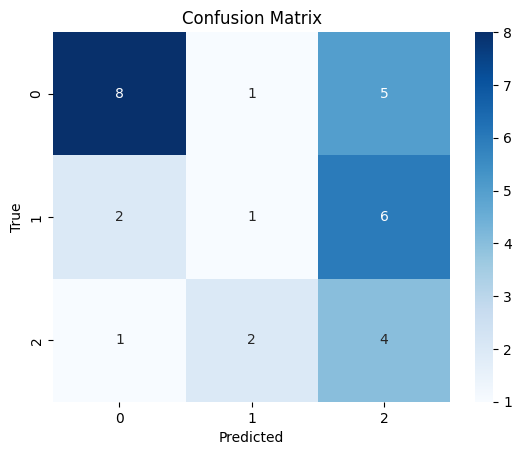

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Enhanced PureKAN Layer
class EnhancedPureKANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=50):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        # Initialize coefficients with smaller variance for stability
        self.coeffs = nn.Parameter(torch.randn(out_features, in_features, grid_size) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_features))
        # Dynamic grid with slight nonlinearity
        self.register_buffer('grid', torch.linspace(-1, 1, grid_size).tanh())

    def forward(self, x):
        batch_size = x.size(0)
        # Improved normalization: tanh for wider range
        x_norm = torch.tanh(x)
        # Scale to grid range
        scaled = (x_norm + 1) * (self.grid_size - 1) / 2  # Map [-1, 1] to [0, grid_size-1]
        idx = scaled.long().clamp(0, self.grid_size - 2)
        frac = scaled - idx.float()
        output = torch.zeros(batch_size, self.out_features, device=x.device)
        for o in range(self.out_features):
            for i in range(self.in_features):
                left_coeff = self.coeffs[o, i, idx[:, i]]
                right_coeff = self.coeffs[o, i, idx[:, i] + 1]
                output[:, o] += (1 - frac[:, i]) * left_coeff + frac[:, i] * right_coeff
        output += self.bias.unsqueeze(0)
        return output

# PureKAN Classifier with Layer Normalization
class PureKANClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], output_dim=3, grid_size=50):
        super().__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList([
            EnhancedPureKANLayer(dims[i], dims[i+1], grid_size)
            for i in range(len(dims)-1)
        ])
        # Layer normalization for hidden layers
        self.norms = nn.ModuleList([
            nn.LayerNorm(dims[i+1]) for i in range(len(dims)-2)
        ])

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = self.norms[i](x)  # Normalize hidden layer outputs
        x = self.layers[-1](x)  # No norm on output layer
        return x

# Load Iris dataset
data = load_iris()
X = data.data
y = data.target

scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Dataset splitting
dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)  # Smaller batch size
test_loader = DataLoader(test_set, batch_size=16)

# Initialize model
model = PureKANClassifier(input_dim=X.shape[1], hidden_dims=[128, 64], output_dim=3, grid_size=50)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training function
def train_classifier(model, loader, optimizer, criterion, scheduler=None, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            epoch_loss += loss.item()
        if scheduler:
            scheduler.step()
        avg_loss = epoch_loss / len(loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluation function (unchanged)
def evaluate_classifier(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

# Confusion matrix plot (unchanged)
def plot_confusion(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Run training and evaluation
train_classifier(model, train_loader, optimizer, criterion, scheduler, num_epochs=50)
test_accuracy = evaluate_classifier(model, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
plot_confusion(model, test_loader)

Epoch 10/100, Loss: 3.1247
Epoch 20/100, Loss: 1.2968
Epoch 30/100, Loss: 0.8864
Epoch 40/100, Loss: 0.6636
Epoch 50/100, Loss: 0.5785
Epoch 60/100, Loss: 0.5597
Epoch 70/100, Loss: 0.4372
Epoch 80/100, Loss: 0.4160
Epoch 90/100, Loss: 0.4188
Epoch 100/100, Loss: 0.3580


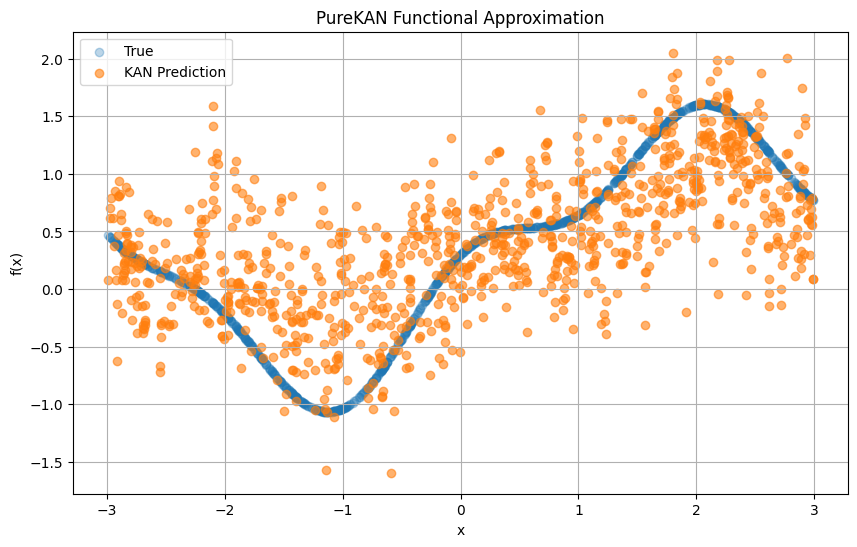

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Synthetic nonlinear function regression task (ideal for KAN)
def generate_function_dataset(n_samples=1000):
    x = np.random.uniform(-3, 3, (n_samples, 1))
    y = np.sin(x) + 0.3 * np.cos(3 * x) + 0.1 * x**2
    return x.astype(np.float32), y.astype(np.float32)

# Optimized PureKAN Layer
class OptimizedPureKANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=64):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.coeffs = nn.Parameter(torch.randn(out_features, in_features, grid_size))
        self.bias = nn.Parameter(torch.randn(out_features))
        self.register_buffer('grid', torch.linspace(0, 1, grid_size))

    def forward(self, x):
        batch_size = x.size(0)
        x_norm = torch.sigmoid(x)
        scaled = x_norm * (self.grid_size - 1)
        idx = scaled.long().clamp(0, self.grid_size - 2)
        frac = scaled - idx.float()
        output = torch.zeros(batch_size, self.out_features, device=x.device)
        for o in range(self.out_features):
            for i in range(self.in_features):
                left_coeff = self.coeffs[o, i, idx[:, i]]
                right_coeff = self.coeffs[o, i, idx[:, i] + 1]
                output[:, o] += (1 - frac[:, i]) * left_coeff + frac[:, i] * right_coeff
        output += self.bias.unsqueeze(0)
        return output

# PureKAN Regressor
class PureKANRegressor(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[64, 32], output_dim=1, grid_size=64):
        super().__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList([
            OptimizedPureKANLayer(dims[i], dims[i+1], grid_size)
            for i in range(len(dims)-1)
        ])

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = torch.relu(x)
        return x

# Load nonlinear function regression dataset
X_np, y_np = generate_function_dataset(n_samples=1000)
scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X_np), dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

# Dataset split
dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

# Initialize model
model = PureKANRegressor(input_dim=1, hidden_dims=[64, 32], output_dim=1, grid_size=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Training loop
def train_regressor(model, loader, optimizer, criterion, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluation and plot
def evaluate_and_plot(model, X_raw, y_true):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(scaler.transform(X_raw), dtype=torch.float32)
        preds = model(X_tensor).numpy()
    plt.figure(figsize=(10, 6))
    plt.scatter(X_raw, y_true, label='True', alpha=0.3)
    plt.scatter(X_raw, preds, label='KAN Prediction', alpha=0.6)
    plt.legend()
    plt.title('PureKAN Functional Approximation')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True)
    plt.show()

# Run training and evaluation
train_regressor(model, train_loader, optimizer, criterion, num_epochs=100)
evaluate_and_plot(model, X_np, y_np)

Epoch 1, Loss: 9.2979
Epoch 2, Loss: 6.8442
Epoch 3, Loss: 6.2085
Epoch 4, Loss: 5.0608
Epoch 5, Loss: 4.5227
Epoch 6, Loss: 4.6659
Epoch 7, Loss: 3.7864
Epoch 8, Loss: 3.4170
Epoch 9, Loss: 2.8356
Epoch 10, Loss: 2.5026
Epoch 11, Loss: 3.4340
Epoch 12, Loss: 2.8417
Epoch 13, Loss: 2.3771
Epoch 14, Loss: 2.0823
Epoch 15, Loss: 1.8590
Epoch 16, Loss: 2.8017
Epoch 17, Loss: 2.1925
Epoch 18, Loss: 1.7215
Epoch 19, Loss: 1.5774
Epoch 20, Loss: 1.4416
Epoch 21, Loss: 1.7633
Epoch 22, Loss: 1.5461
Epoch 23, Loss: 1.2815
Epoch 24, Loss: 1.0872
Epoch 25, Loss: 0.9617
Epoch 26, Loss: 1.4142
Epoch 27, Loss: 1.2170
Epoch 28, Loss: 1.0333
Epoch 29, Loss: 0.9251
Epoch 30, Loss: 0.8314
Epoch 31, Loss: 1.3429
Epoch 32, Loss: 1.1162
Epoch 33, Loss: 0.9282
Epoch 34, Loss: 0.8128
Epoch 35, Loss: 0.7214
Epoch 36, Loss: 0.9651
Epoch 37, Loss: 0.8449
Epoch 38, Loss: 0.7116
Epoch 39, Loss: 0.5899
Epoch 40, Loss: 0.5160
Epoch 41, Loss: 0.8341
Epoch 42, Loss: 0.7471
Epoch 43, Loss: 0.6563
Epoch 44, Loss: 0.57

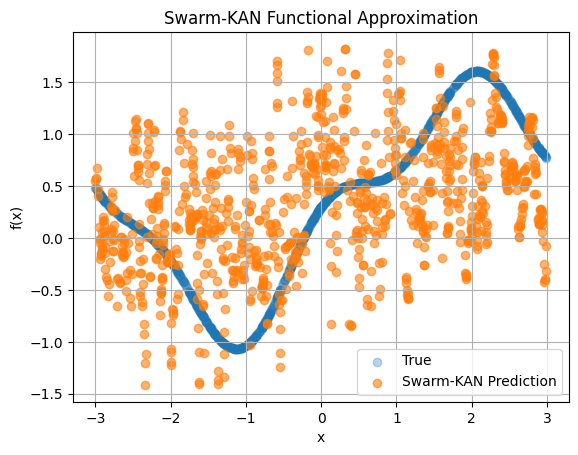

In [ ]:
# Swarm-based Kolmogorov-Arnold Network (Swarm-KAN) Prototype

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Swarm Agent Activation Function
class SwarmKANActivation(nn.Module):
    def __init__(self, grid_size=20, influence_rate=0.05):
        super().__init__()
        self.grid_size = grid_size
        self.influence_rate = influence_rate
        self.register_buffer('grid', torch.linspace(0, 1, grid_size))
        self.coeffs = nn.Parameter(torch.randn(grid_size))

        # Local memory for swarm feedback (past coeffs)
        self.register_buffer('memory', self.coeffs.detach().clone())

    def forward(self, x):
        x_norm = torch.sigmoid(x)
        scaled = x_norm * (self.grid_size - 1)
        idx = scaled.long().clamp(0, self.grid_size - 2)
        frac = scaled - idx.float()
        left = self.coeffs[idx]
        right = self.coeffs[idx + 1]
        return (1 - frac) * left + frac * right

    def swarm_update(self, neighbor_coeffs):
        # Apply local swarm influence (cohesion-style blending)
        mean_neighbor = neighbor_coeffs.mean(dim=0)
        self.coeffs.data = (1 - self.influence_rate) * self.coeffs.data + self.influence_rate * mean_neighbor

# Swarm-KAN Layer
class SwarmKANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid_size=20, influence_rate=0.05):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.activations = nn.ModuleList([
            SwarmKANActivation(grid_size, influence_rate)
            for _ in range(in_features * out_features)
        ])

    def forward(self, x):
        batch_size = x.size(0)
        out = torch.zeros(batch_size, self.out_features, device=x.device)
        idx = 0
        for o in range(self.out_features):
            for i in range(self.in_features):
                out[:, o] += self.weights[o, i] * self.activations[idx](x[:, i])
                idx += 1
        return out

    def swarm_step(self):
        # Swarm-style local influence update among activations
        all_coeffs = torch.stack([a.coeffs.detach() for a in self.activations])
        for i, a in enumerate(self.activations):
            neighbor_ids = torch.randint(0, len(self.activations), (3,))  # random 3 neighbors
            neighbor_coeffs = all_coeffs[neighbor_ids]
            a.swarm_update(neighbor_coeffs)

# Full Swarm-KAN Network
class SwarmKAN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 16], output_dim=1, grid_size=20, influence_rate=0.05):
        super().__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList([
            SwarmKANLayer(dims[i], dims[i+1], grid_size, influence_rate)
            for i in range(len(dims)-1)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def swarm_step_all(self):
        for layer in self.layers:
            layer.swarm_step()

# Synthetic nonlinear dataset
def generate_data(n=1000):
    x = np.random.uniform(-3, 3, (n, 1)).astype(np.float32)
    y = np.sin(x) + 0.3 * np.cos(3 * x) + 0.1 * x**2
    return x, y

# Training loop
def train_swarm_kan(model, X_train, y_train, epochs=50, swarm_interval=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % swarm_interval == 0:
            model.swarm_step_all()

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Visualization
def plot_results(model, X_test, y_true):
    with torch.no_grad():
        preds = model(X_test).detach().cpu().numpy()
    plt.scatter(X_test.cpu().numpy(), y_true.cpu().numpy(), alpha=0.3, label='True')
    plt.scatter(X_test.cpu().numpy(), preds, alpha=0.6, label='Swarm-KAN Prediction')
    plt.title("Swarm-KAN Functional Approximation")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run experiment
if __name__ == "__main__":
    X_np, y_np = generate_data(n=1000)
    X_train = torch.tensor(X_np, dtype=torch.float32)
    y_train = torch.tensor(y_np, dtype=torch.float32)

    model = SwarmKAN(input_dim=1, hidden_dims=[32, 16], output_dim=1, grid_size=20, influence_rate=0.1)
    train_swarm_kan(model, X_train, y_train, epochs=50, swarm_interval=5)
    plot_results(model, X_train, y_train)